**Notebook credit**: based on the F. Chollet's original notebook [here](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter04_getting-started-with-neural-networks.ipynb).

## Predicting house prices: A regression example

We have discussed _regression problems_ before
These consist of predicting a continuous value instead of a discrete label:
- predicting the temperature tomorrow, given meteorological data
- predicting the time that a software project will take to complete, given its specifications

However, we only discussed the linear regression case before where our predictions models were *linear*. Deep learning allows us to buil complex *non-linear* prediction models.

## The Boston Housing Price dataset

- we’ll predict the median price of homes in a given Boston suburb in the mid-1970s
- features of the suburb include things like the crime rate, the local property tax rate, and so on
- it has relatively few data points: only 506, split between 404 training samples and 102 test samples
- each feature in the input data (for example, the crime rate) has a different scale
  - some values are proportions, which take values between 0 and 1
  - others take values between 1 and 12
  - others between 0 and 100, and so on.

**Loading the Boston housing dataset**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:

from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 1us/step


### train data 的形状: 404 examples, 13 个 features each

In [3]:
train_data.shape # 404 training examples with 13 features each

(404, 13)

In [12]:
train_data[0:5]

array([[-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
        -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
         1.14850044,  0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, -0.25683275, -1.21518188,
         1.89434613, -1.91036058,  1.24758524, -0.85646254, -0.34843254,
        -1.71818909,  0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , -0.25683275,  0.62864202,
        -1.82968811,  1.11048828, -1.18743907,  1.67588577,  1.5652875 ,
         0.78447637,  0.22061726, -1.30850006],
       [-0.40149354, -0.48361547, -0.86940196, -0.25683275, -0.3615597 ,
        -0.3245576 , -1.23667187,  1.10717989, -0.51114231, -1.094663  ,
         0.78447637,  0.44807713, -0.65292624],
       [-0.0056343 , -0.48361547,  1.0283258 , -0.25683275,  1.32861221,
         0.15364225,  0.69480801, -0.57857203,  1.67588577,  1.5652875 ,
         0.78447637,  0.3898823 ,  0.26349695]])

There is quite a bit of variation in the ranges that the 13 features lie in. The features themselves are described [here](http://lib.stat.cmu.edu/datasets/boston).

In [4]:
tf.reduce_min(train_data, axis=0).numpy()

array([6.3200e-03, 0.0000e+00, 4.6000e-01, 0.0000e+00, 3.8500e-01,
       3.5610e+00, 2.9000e+00, 1.1296e+00, 1.0000e+00, 1.8800e+02,
       1.2600e+01, 3.2000e-01, 1.7300e+00])

In [5]:
tf.reduce_max(train_data, axis=0).numpy()

array([ 88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,   8.725 ,
       100.    ,  10.7103,  24.    , 711.    ,  22.    , 396.9   ,
        37.97  ])

In [6]:
test_data.shape # 102 training examples with 13 features each

(102, 13)

In [7]:
train_targets[:10] # prices in 1000s of dollar! good old days :)

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [13]:
[train_targets.min(), train_targets.max()] # prices range from 5K to 50K

[5.0, 50.0]

## 数据预处理: Feature-wise Normalization

由于我们的数据有 13 个 features, 每个的数据尺度不同, 所以最后的结果可能会非常倾向于把大的权重赋给数据尺度大的 feature. 因而我们需要对数据进行一些 normalization.

- widespread best practice is to do feature-wise normalization
- for each feature in the input data (a column in the input data matrix):
  - subtract the mean of the feature, and
  - divide by the standard deviation
- after this normalization, every feature is centered around 0 and has a unit standard deviation

### **Normalizing the data**

In [15]:
mean = train_data.mean(axis=0)   # compute column means means move along rows, i.e., axis=0
train_data -= mean               # not same shape, broadcasting occurs
std = train_data.std(axis=0)     # compute column std
train_data /= std
test_data -= mean                # we do NOT use test set mean and std!
test_data /= std

### Building your model

- because few samples are available, we'll use a very small model
- two intermediate layers, each with 64 units
- the less training data you have, the worse overfitting will be
- using a small model is one way to mitigate overfitting

## **Model definition**. 新的 loss function 和 metrics

`"mse"` = mean squared error

`"mae"` = mean absolute error

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # final layer is linear, linear regression corresponds to just having this layer
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"]) # mse will be used a loss, but mae will also be monitored
    return model

## K-fold validation

K-fold validation 的意思是将数据集分成 K 个 folds;
模型训练时将会进行 K 次, 每次选取其中一个不同的子集作为验证集, 其余的K-1个子集作为训练集; 通过这种方式, 每个数据点都会被用作验证集一次, 作为训练集K-1次;
最终模型的性能是这K次训练验证中得到的性能指标的平均值.

K-fold validation 可以提高数据利用率, 减少过拟合, 但是也有一些 drawbacks:

- but we have so few data points
- validation set would end up being very small (e.g., about 100 examples
- validation scores might change a lot depending on which data points we chose for validation and which we chose for training
- the validation scores might have a high variance with regard to the validation split
- would prevent us from reliably evaluating our model.
- best practice in such situations is to use K-fold cross-validation (see figure 4.8)

<img src="https://github.com/ambujtewari/stats315-winter2022/raw/main/images/k-fold.png" width="500">

**K-fold validation**

In [17]:
k = 4
num_val_samples = len(train_data) // k  # note: integer division
num_epochs = 50 # don't know yet whether this is a good choice
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]       # extract validation examples
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] # extract validation labels
    partial_train_data = np.concatenate(                                        # whatever is left after extraction becomes partial training data
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(                                     # partial training labels
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)                       # verbose=0 doesn't print anything while fitting
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
all_scores

[2.075955629348755, 2.3421809673309326, 2.487363815307617, 2.453495979309082]

In [ ]:
np.mean(all_scores)

2.3397490978240967

- different runs do indeed show rather different validation scores
- average validation score is a much more reliable metric than any single score
- how much are we off on average?
- is it significant? (recall that prices range from 5k to 50k)

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 300 # increased this from 50 to 300
all_mae_histories = [] # will store entire mae history as opposed to a single score
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),                # we now use the validation_data argument
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]                                    # store the entire history of the validation mae values
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
len(all_mae_histories) # is a list containing 4 lists, each containing the val_mae history for a fold

4

In [ ]:
for i in range(9): # the val_mae will typically be quite high for early epochs
  mean = np.mean([x[i] for x in all_mae_histories]) # the average val_mae, over 4 folds, for epoch i
  print(f"{mean:.2f}", end = " ")

19.40 15.97 11.85 8.08 5.92 4.96 4.29 3.91 3.64 

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [                        # list whose entry i is
    np.mean([x[i] for x in all_mae_histories]) # the mean, over folds, of the val_mae
    for i in range(num_epochs)                 # at epoch i
    ]

**Plotting validation scores**

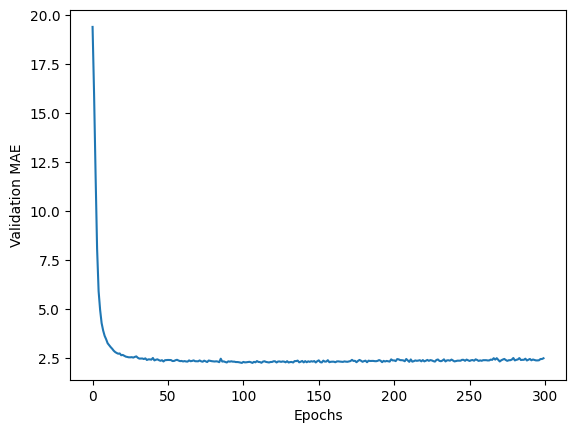

In [ ]:
plt.plot(range(len(average_mae_history)), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

- as we saw earlier, the first 10 data points have high validation MAE
- makes it a little difficult to read the plot
- let's replot after omitting the first 10 points

**Plotting validation scores, excluding the first 10 data points**

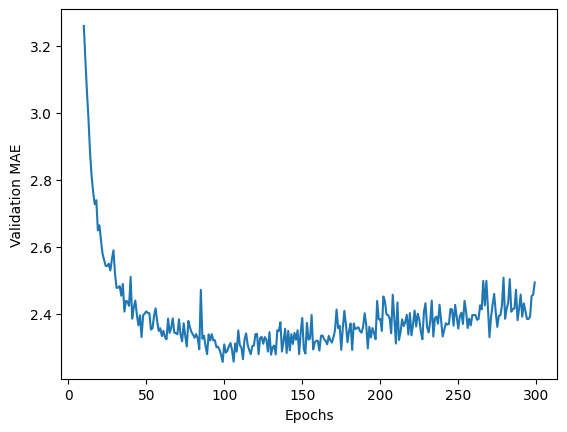

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(10, len(average_mae_history)), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

- validation MAE stops improving significantly after 120–140 epochs
- past that point, we start *overfitting*


**Training the final model**

- Here we only tuned number of epochs
- you could also adjust the size of the intermediate layers
- once you're finished tuning, you can train a final production model
- this will use _all_ of the training data
- it will use the best choices for tuning parameters (e.g., 130 for epochs in our case)
- you will evaluate its performance on the test data (that we haven't touched at all so far)

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 5ms/step - loss: 17.1215 - mae: 2.6025


In [ ]:
test_mae_score

2.6024649143218994

### Generating predictions on new data

In [ ]:
predictions = model.predict(test_data)
predictions[0] # price prediction for the first house in test set (in 1000s of dollars)

array([9.572728], dtype=float32)